### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Tercera tarea programada 2023-I


Profesora: María Auxiliadora Mora

Medio de entrega: Por medio del TEC-Digital.

Entregables: Un archivo en Jupyter ( .IPYNB ). 

Modo de trabajo: Individual o en grupos de máximo dos personas.

- Jonathan Quesada Salas
- Rodolfo Cruz Vega

In [ ]:
# ======================================================
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# ======================================================
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# ======================================================
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# ======================================================
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# ======================================================
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# ======================================================

# 1. Describa el problema y el objetivo del ejercicio. #

El problema del ejercicio consisten en implementar una red neuronal profunda utilizando capas convolucionales en PyTorch para clasificar imágenes del conjunto de datos "BIRDS 525 SPECIES- IMAGE CLASSIFICATION". El objetivo es construir un modelo de aprendizaje profundo que pueda reconocer y clasificar diferentes especies de aves en imágenes.

La tarea consiste en implementar una red neuronal profunda utilizando capas convolucionales en PyTorch, entrenar el modelo utilizando el conjunto de datos de entrenamiento y evaluar su rendimiento utilizando el conjunto de datos de prueba. El objetivo es lograr una alta precisión de clasificación en las especies de aves seleccionadas.

# 2. Describa los datos utilizados en el ejercicio. Para el ejercicio utilice el siguientes conjuntos de datos: #

Para el ejercicio deben utilizar al menos el 30% de las clases del siguientes conjunto de datos:
• BIRDS 525 SPECIES- IMAGE CLASSIFICATION:
https://www.kaggle.com/datasets/gpiosenka/100-bird-species

En el ejercicio de clasificación de imágenes de especies de aves, se utilizó el conjunto de datos "BIRDS 525 SPECIES- IMAGE CLASSIFICATION". A continuación, se describe la estructura y características de los datos:

Número de especies: El conjunto de datos contiene imágenes de 525 especies diferentes de aves.

Distribución de los conjuntos de datos:

Conjunto de entrenamiento: Contiene 84,635 imágenes de entrenamiento.
Conjunto de prueba: Contiene 2,625 imágenes de prueba, con 5 imágenes por especie.
Conjunto de validación: Contiene 2,625 imágenes de validación, con 5 imágenes por especie.
Formato de las imágenes: Todas las imágenes están en formato JPG.

Dimensiones de las imágenes: Cada imagen tiene un tamaño de 224x224 píxeles.

Calidad y contenido de las imágenes: Se menciona que el conjunto de datos es de alta calidad, con imágenes en las que solo aparece una única ave y esta ocupa al menos el 50% de los píxeles de la imagen. Además, se menciona que no se han utilizado técnicas de aumentación de datos, por lo que las imágenes son originales y no se han creado mediante técnicas de generación artificial.

Estructura de los datos: El conjunto de datos está organizado en subdirectorios, uno para cada especie de ave. Se utiliza la estructura de directorios para facilitar la carga de los datos utilizando la función ImageDataGenerator.flow_from_directory de Keras.

Archivo "birds.csv": El conjunto de datos incluye un archivo CSV llamado "birds.csv". Este archivo contiene cinco columnas:

"filepaths": Ruta relativa al archivo de imagen.
"labels": Nombre de la clase de especie de ave asociada a la imagen.
"scientific label": Nombre científico en latín de la especie de ave.
"dataset": Indica a qué conjunto de datos pertenece la imagen (entrenamiento, prueba o validación).
"class_id": Valor del índice de clase asociado a la especie de ave.



# 3. Cargue, escale y explore los datos #

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

Extraer el 30% de las clases de 100-bird-species

In [ ]:
# ======================================================
# Importar los módulos necesarios
# ======================================================
import os
import random
import shutil
# ======================================================
# Definir la ruta del directorio de entrenamiento que contiene las imágenes de las aves
# ======================================================
train_dir = '/kaggle/input/100-bird-species/train'
# ======================================================
# Obtener la lista de nombres de las clases de aves
# ======================================================
class_names = os.listdir(train_dir)
# ======================================================
# Calcular el número de clases y seleccionar un subconjunto al azar
# ======================================================
num_classes = len(class_names)
num_classes_sub = int(0.3 * num_classes)
selected_classes = random.sample(class_names, num_classes_sub)
# ======================================================
# Definir las rutas de los directorios de subconjuntos
# ======================================================
sub_train_dir = '/kaggle/working/sub/sub_train'
sub_test_dir = '/kaggle/working/sub/sub_test'
sub_valid_dir = '/kaggle/working/sub/sub_valid'
# ======================================================
# Crear los directorios de subconjuntos si no existen
# ======================================================
os.makedirs(sub_train_dir, exist_ok=True)
os.makedirs(sub_test_dir, exist_ok=True)
os.makedirs(sub_valid_dir, exist_ok=True)
# ======================================================
# Iterar sobre cada clase seleccionada
# ======================================================
for class_name in selected_classes:
    # ======================================================
    # Definir las rutas de los directorios de la clase actual en los subconjuntos
    # ======================================================
    class_train_dir = os.path.join(train_dir, class_name)
    class_sub_train_dir = os.path.join(sub_train_dir, class_name)
    class_sub_test_dir = os.path.join(sub_test_dir, class_name)
    class_sub_valid_dir = os.path.join(sub_valid_dir, class_name)
    # ======================================================
    # Crear los directorios de subconjuntos para la clase actual si no existen
    # ======================================================
    os.makedirs(class_sub_train_dir, exist_ok=True)
    os.makedirs(class_sub_test_dir, exist_ok=True)
    os.makedirs(class_sub_valid_dir, exist_ok=True)
    # ======================================================
    # Copiar una fracción aleatoria de las imágenes de entrenamiento a la nueva ruta del subconjunto de entrenamiento
    # ======================================================
    class_images = os.listdir(class_train_dir)
    selected_images = random.sample(class_images, int(0.3 * len(class_images)))
    
    for image_name in selected_images:
        src_path = os.path.join(class_train_dir, image_name)
        dest_path = os.path.join(class_sub_train_dir, image_name)
        shutil.copy(src_path, dest_path)
    # ======================================================
    # Copiar todas las imágenes de la clase a los directorios de subconjuntos de prueba y validación
    # ======================================================
    for split_dir in [sub_test_dir, sub_valid_dir]:
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)
        
        for image_name in class_images:
            src_path = os.path.join(train_dir, class_name, image_name)
            dest_path = os.path.join(class_split_dir, image_name)
            shutil.copy(src_path, dest_path)

Verificar la cantidad de imagenes y clases en sub_train_dir

Total number of classes: 157


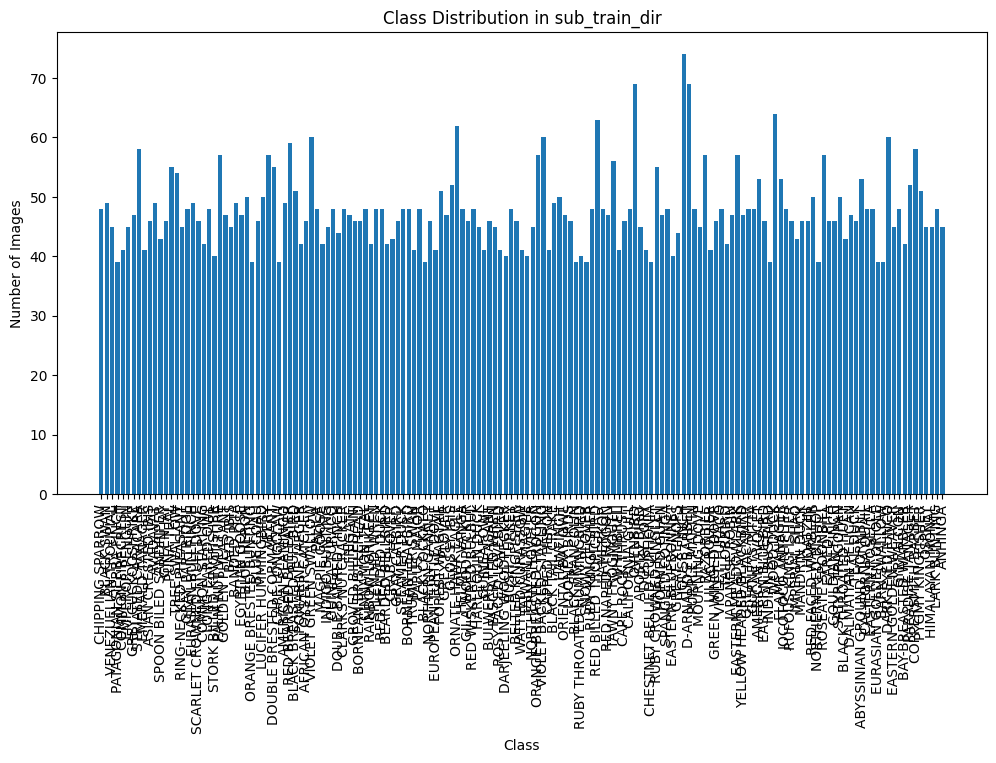

In [ ]:
import os
import matplotlib.pyplot as plt
# ======================================================
# Definir la ruta del directorio de subconjunto de entrenamiento
# ======================================================
sub_train_dir = '/kaggle/working/sub/sub_train'
# ======================================================
# Obtener la lista de nombres de las clases de aves en el subconjunto de entrenamiento
# ======================================================
class_names = os.listdir(sub_train_dir)
# ======================================================
# Calcular el número total de clases
# ======================================================
num_classes = len(class_names)
print("Total number of classes:", num_classes)
# ======================================================
# Obtener el número de imágenes por clase y almacenarlos en una lista
# ======================================================
class_counts = []
for class_name in class_names:
    class_dir = os.path.join(sub_train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)
# ======================================================
# Crear un gráfico de barras para visualizar la distribución de clases
# ======================================================
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in sub_train_dir")
plt.xticks(rotation=90)
plt.show()

Verificar la cantidad de imagenes y clases en sub_test_dir

Total number of classes: 157


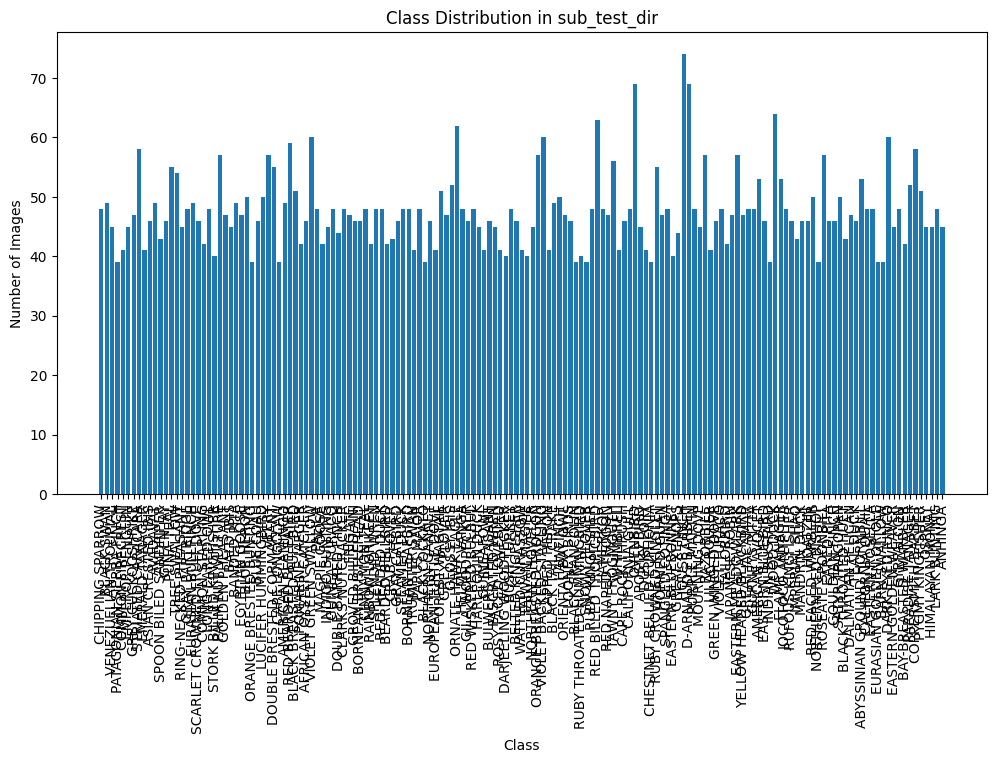

In [ ]:
import os
import matplotlib.pyplot as plt
# ======================================================
# Definir la ruta del directorio de subconjunto de prueba
# ======================================================
sub_test_dir = '/kaggle/working/sub/sub_test'
# ======================================================
# Obtener la lista de nombres de las clases de aves en el subconjunto de prueba
# ======================================================
class_names = os.listdir(sub_test_dir)
# ======================================================
# Calcular el número total de clases
# ======================================================
num_classes = len(class_names)
print("Total number of classes:", num_classes)
# ======================================================
# Obtener el número de imágenes por clase y almacenarlos en una lista
# ======================================================
class_counts = []
for class_name in class_names:
    class_dir = os.path.join(sub_test_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)
# ======================================================
# Crear un gráfico de barras para visualizar la distribución de clases
# ======================================================
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in sub_test_dir")
plt.xticks(rotation=90)
plt.show()

Verificar la cantidad de imagenes y clases en sub_valid_dir

Total number of classes: 157


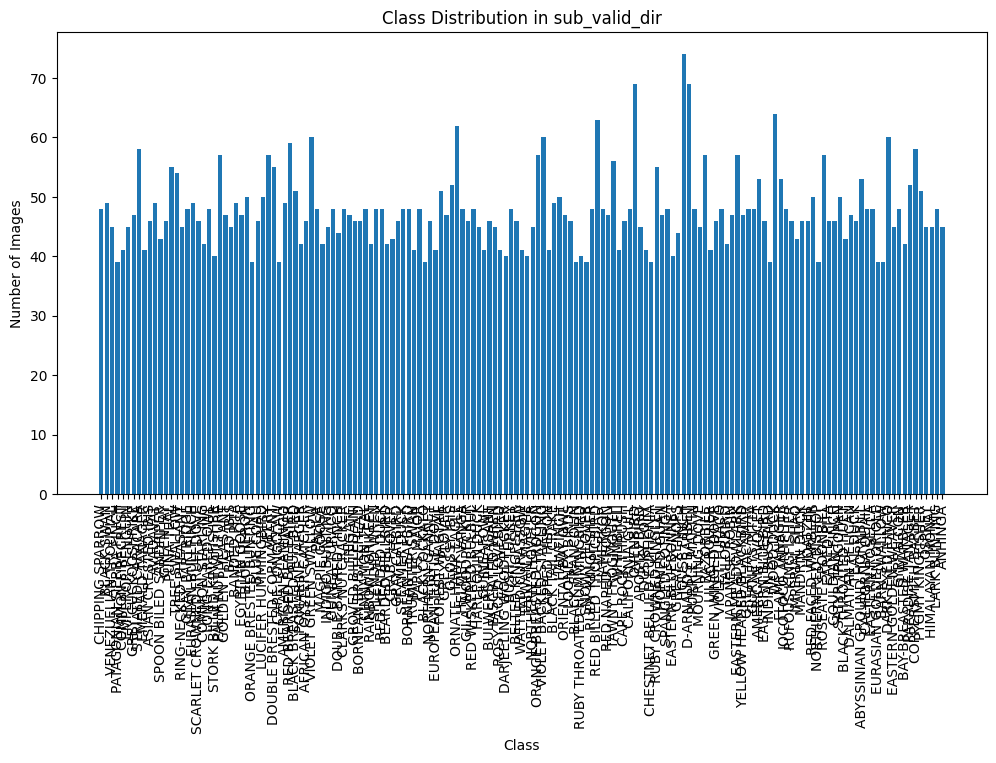

In [ ]:
import os
import matplotlib.pyplot as plt
# ======================================================
# Definir la ruta del directorio de subconjunto de validación
# ======================================================
sub_valid_dir = '/kaggle/working/sub/sub_valid'
# ======================================================
# Obtener la lista de nombres de las clases de aves en el subconjunto de validación
# ======================================================
class_names = os.listdir(sub_valid_dir)
# ======================================================
# Calcular el número total de clases
# ======================================================
num_classes = len(class_names)
print("Total number of classes:", num_classes)
# ======================================================
# Obtener el número de imágenes por clase y almacenarlos en una lista
# ======================================================
class_counts = []
for class_name in class_names:
    class_dir = os.path.join(sub_train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)
# ======================================================
# Crear un gráfico de barras para visualizar la distribución de clases
# ======================================================
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in sub_valid_dir")
plt.xticks(rotation=90)
plt.show()

## Balancear clases ##

El balanceo de clases es una técnica utilizada en problemas de clasificación cuando las clases están desproporcionadamente representadas en el conjunto de datos (Kushwaha, 2019).

Se busca abordar estas desventajas y mejorar el rendimiento del modelo al igualar la cantidad de ejemplos de cada clase. En este caso se realiza mediante la técnica de submuestreo (eliminar ejemplos de las clases dominantes). Además esto nos facilita al realizar el entrenamiento haciendo un subconjunto de datos más manejable. 

Balancear sub_train_dir

In [ ]:
import os
import random
import shutil

sub_train_dir = '/kaggle/working/sub/sub_train'
# ======================================================
# Get the class directories
# ======================================================
class_names = os.listdir(sub_train_dir)
# ======================================================
# Calculate the minimum number of samples in a class
# ======================================================
min_samples = min([len(os.listdir(os.path.join(sub_train_dir, class_name))) for class_name in class_names])
# ======================================================
# Define the balanced directory
# ======================================================
balanced_dir = '/kaggle/working/sub/sub_train_balanced'
os.makedirs(balanced_dir, exist_ok=True)
# ======================================================
# Iterate over each class
# ======================================================
for class_name in class_names:
    class_dir = os.path.join(sub_train_dir, class_name)
    class_images = os.listdir(class_dir)
    # ======================================================
    # Randomly select 'min_samples' number of images
    # ======================================================
    selected_images = random.sample(class_images, min_samples)
    # ======================================================
    # Copy the selected images to the balanced directory
    # ======================================================
    for image_name in selected_images:
        src_path = os.path.join(class_dir, image_name)
        dest_path = os.path.join(balanced_dir, class_name, image_name)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)
# ======================================================
# Update the sub_train_dir to the balanced directory
# ======================================================
sub_train_dir = balanced_dir
# ======================================================
# Validate the balanced class distribution
# ======================================================
class_names_balanced = os.listdir(sub_train_dir)

for class_name in class_names_balanced:
    class_dir = os.path.join(sub_train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    #print("Class:", class_name, "Number of images:", num_images)

Total number of classes: 157


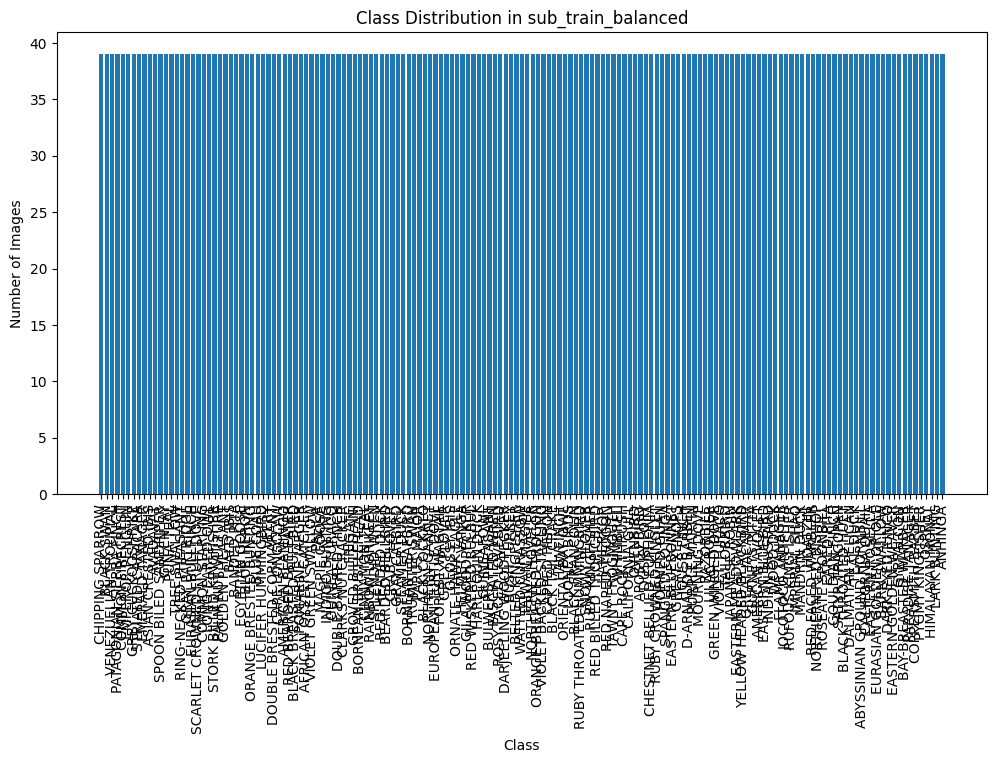

In [ ]:
import os
import matplotlib.pyplot as plt
# ======================================================
# Definir la ruta del directorio de subconjunto de entrenamiento balanceado
# ======================================================
balanced_dir = '/kaggle/working/sub/sub_train_balanced'
# ======================================================
# Obtener la lista de nombres de las clases de aves en el subconjunto de entrenamiento balanceado
# ======================================================
class_names = os.listdir(balanced_dir)
# ======================================================
# Calcular el número total de clases
# ======================================================
num_classes = len(class_names)
print("Total number of classes:", num_classes)
# ======================================================
# Obtener el número de imágenes por clase y almacenarlos en una lista
# ======================================================
class_counts = []
for class_name in class_names:
    class_dir = os.path.join(sub_train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)
# ======================================================
# Crear un gráfico de barras para visualizar la distribución de clases
# ======================================================
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in sub_train_balanced")
plt.xticks(rotation=90)
plt.show()

Balancear sub_test_dir

In [ ]:
import os
import random
import shutil

sub_test_dir = '/kaggle/working/sub/sub_test'
# ======================================================
# Get the class directories
# ======================================================
class_names = os.listdir(sub_test_dir)
# ======================================================
# Calculate the minimum number of samples in a class
# ======================================================
min_samples = min([len(os.listdir(os.path.join(sub_test_dir, class_name))) for class_name in class_names])
# ======================================================
# Define the balanced directory
# ======================================================
balanced_dir = '/kaggle/working/sub/sub_test_balanced'
os.makedirs(balanced_dir, exist_ok=True)
# ======================================================
# Iterate over each class
# ======================================================
for class_name in class_names:
    class_dir = os.path.join(sub_test_dir, class_name)
    class_images = os.listdir(class_dir)
    # ======================================================
    # Randomly select 'min_samples' number of images
    # ======================================================
    selected_images = random.sample(class_images, min_samples)
    # ======================================================
    # Copy the selected images to the balanced directory
    # ======================================================
    for image_name in selected_images:
        src_path = os.path.join(class_dir, image_name)
        dest_path = os.path.join(balanced_dir, class_name, image_name)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)
# ======================================================
# Update the sub_test_dir to the balanced directory
# ======================================================
sub_test_dir = balanced_dir
# ======================================================
# Validate the balanced class distribution
# ======================================================
class_names_balanced = os.listdir(sub_test_dir)

for class_name in class_names_balanced:
    class_dir = os.path.join(sub_test_dir, class_name)
    num_images = len(os.listdir(class_dir))
    #print("Class:", class_name, "Number of images:", num_images)

Total number of classes: 157


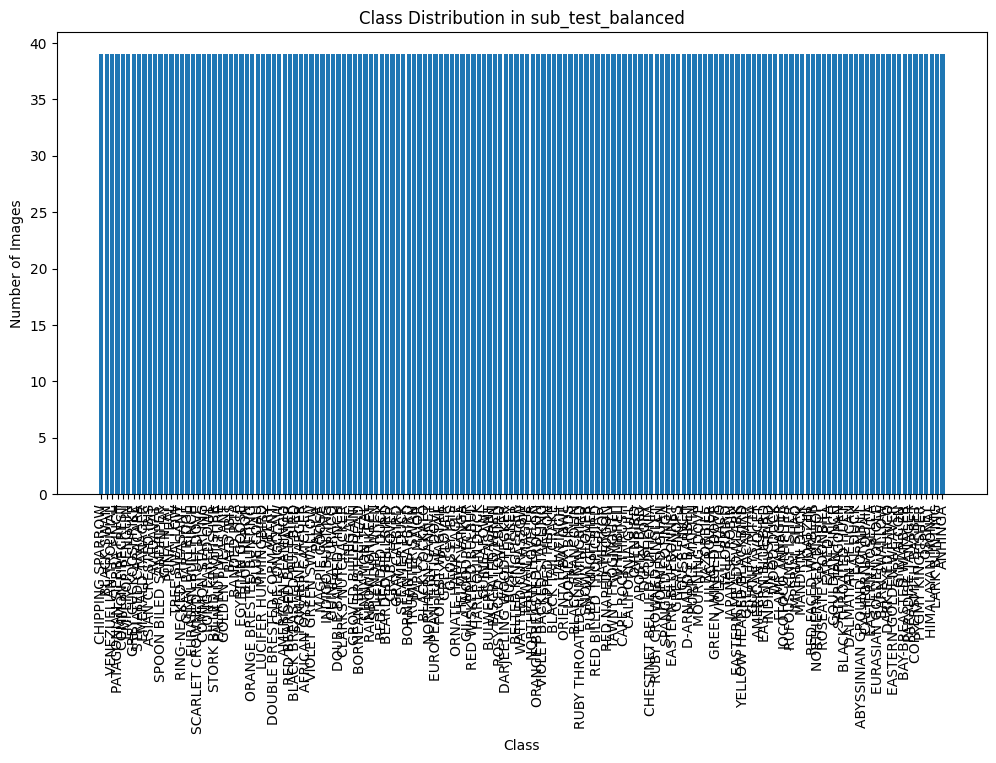

In [ ]:
import os
import matplotlib.pyplot as plt

balanced_dir = '/kaggle/working/sub/sub_test_balanced'

class_names = os.listdir(balanced_dir)

num_classes = len(class_names)
print("Total number of classes:", num_classes)
# ======================================================
# Cicle for each classname
# ======================================================
class_counts = []
for class_name in class_names:
    class_dir = os.path.join(sub_train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)
    #print("Class:", class_name, "Number of images:", num_images)
# ======================================================
# Create a bar graph to visualize the class distribution
# ======================================================
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in sub_test_balanced")
plt.xticks(rotation=90)
plt.show()

Balancear sub_test_dir

In [ ]:
sub_valid_dir = '/kaggle/working/sub/sub_valid'
# ======================================================
# Get the class directories
# ======================================================
class_names = os.listdir(sub_valid_dir)
# ======================================================
# Calculate the minimum number of samples in a class
# ======================================================
min_samples = min([len(os.listdir(os.path.join(sub_valid_dir, class_name))) for class_name in class_names])
# ======================================================
# Define the balanced directory
# ======================================================
balanced_dir = '/kaggle/working/sub/sub_valid_balanced'
os.makedirs(balanced_dir, exist_ok=True)
# ======================================================
# Iterate over each class
# ======================================================
for class_name in class_names:
    class_dir = os.path.join(sub_valid_dir, class_name)
    class_images = os.listdir(class_dir)
    # ======================================================
    # Randomly select 'min_samples' number of images
    # ======================================================
    selected_images = random.sample(class_images, min_samples)
    # ======================================================
    # Copy the selected images to the balanced directory
    # ======================================================
    for image_name in selected_images:
        src_path = os.path.join(class_dir, image_name)
        dest_path = os.path.join(balanced_dir, class_name, image_name)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(src_path, dest_path)
# ======================================================
# Update the sub_valid_dir to the balanced directory
# ======================================================
sub_valid_dir = balanced_dir
# ======================================================
# Validate the balanced class distribution
# ======================================================
class_names_balanced = os.listdir(sub_valid_dir)

for class_name in class_names_balanced:
    class_dir = os.path.join(sub_valid_dir, class_name)
    num_images = len(os.listdir(class_dir))
    #print("Class:", class_name, "Number of images:", num_images)

Total number of classes: 157


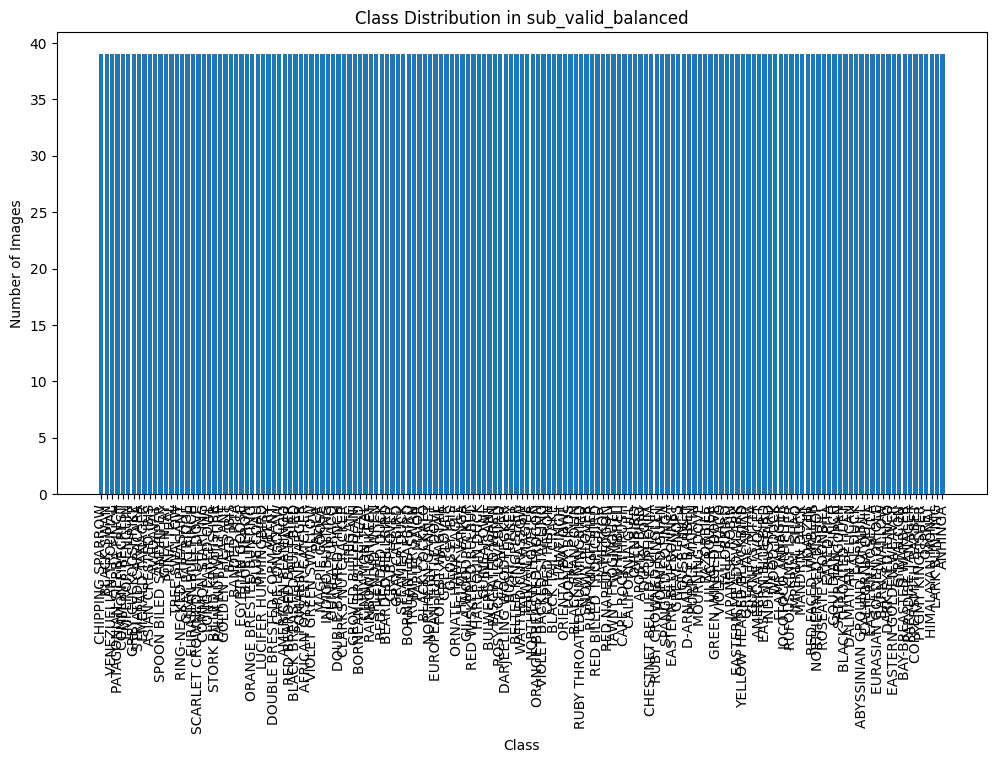

In [ ]:
import os
import matplotlib.pyplot as plt

balanced_dir = '/kaggle/working/sub/sub_valid_balanced'

class_names = os.listdir(balanced_dir)

num_classes = len(class_names)
print("Total number of classes:", num_classes)

class_counts = []
# ======================================================
# Cicle for each classname
# ======================================================
for class_name in class_names:
    class_dir = os.path.join(sub_train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)
    #print("Class:", class_name, "Number of images:", num_images)
# ======================================================
# Create a bar graph to visualize the class distribution
# ======================================================
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in sub_valid_balanced")
plt.xticks(rotation=90)
plt.show()

In [ ]:
import torch
from torchvision import transforms, datasets
# ======================================================
# Rutas de los directorios de entrenamiento, prueba y validación
# ======================================================
train_dir = '/kaggle/working/sub/sub_train_balanced'
test_dir = '/kaggle/working/sub/sub_test_balanced'
valid_dir = '/kaggle/working/sub/sub_valid_balanced'
# ======================================================
# Definir transformaciones de preprocesamiento de datos
# ======================================================
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])
# ======================================================
# Cargar los conjuntos de datos utilizando ImageFolder y aplicar las transformaciones
# ======================================================
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
# ======================================================
# Crear los dataloaders para el conjunto de entrenamiento, prueba y validación
# ======================================================
batch_size = 32  # Ajusta el tamaño del lote según tus necesidades
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [ ]:
class_names = train_data.classes  # Obtiene los nombres de las clases de entrenamiento
print(class_names)

train_labels = []  # Lista para almacenar las etiquetas de entrenamiento
for _, labels in trainloader:  # Recorre los datos de entrenamiento
    train_labels.extend(labels.tolist())  # Extiende las etiquetas de cada lote a la lista train_labels

num_classes = len(set(train_labels))  # Calcula el número de clases únicas en train_labels

print(num_classes)

['ABYSSINIAN GROUND HORNBILL', 'AFRICAN OYSTER CATCHER', 'AMERICAN AVOCET', 'AMERICAN FLAMINGO', 'ANHINGA', 'APOSTLEBIRD', 'ASIAN CRESTED IBIS', 'AVADAVAT', 'BALD IBIS', 'BANDED PITA', 'BARN SWALLOW', 'BAY-BREASTED WARBLER', 'BEARDED BELLBIRD', 'BELTED KINGFISHER', 'BLACK BREASTED PUFFBIRD', 'BLACK COCKATO', 'BLACK FRANCOLIN', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED HUET', 'BLUE COAU', 'BLUE HERON', 'BORNEAN BRISTLEHEAD', 'BORNEAN LEAFBIRD', 'BULWERS PHEASANT', 'BUSH TURKEY', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CAPE LONGCLAW', 'CAPE ROCK THRUSH', 'CAPPED HERON', 'CHESTNET BELLIED EUPHONIA', 'CHIPPING SPARROW', 'CINNAMON TEAL', 'CLARKS NUTCRACKER', 'COMMON FIRECREST', 'COMMON STARLING', 'COPPERSMITH BARBET', 'CRAB PLOVER', 'D-ARNAUDS BARBET', 'DALMATIAN PELICAN', 'DARJEELING WOODPECKER', 'DARK EYED JUNCO', 'DOUBLE BARRED FINCH', 'DOUBLE BRESTED CORMARANT', 'DUSKY LORY', 'EARED PITA', 'EASTERN BLUEBIRD', 'EASTERN BLUEBONNET', 'EASTERN GOLDEN WEAVER', 'EASTERN MEADOWLARK', '

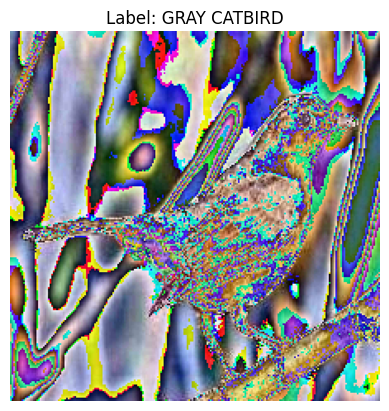

In [ ]:
# ======================================================
# bibliotecas requeridas 
# ======================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# ======================================================
# Obtener un lote de imágenes y etiquetas del conjunto de entrenamiento
# ======================================================
images, labels = next(iter(trainloader))
# ======================================================
# Mostrar una imagen del conjunto de entrenamiento
# ======================================================
plt.imshow(torchvision.transforms.ToPILImage()(images[0]))
plt.title(f"Label: {class_names[labels[0]]}")
plt.axis('off')
plt.show()

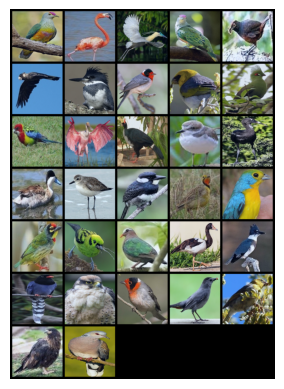

Etiqueta original:  SCARLET CROWNED FRUIT DOVE
Etiqueta original:  AMERICAN FLAMINGO
Etiqueta original:  CAPPED HERON
Etiqueta original:  SCARLET CROWNED FRUIT DOVE
Etiqueta original:  BLACK THROATED HUET
Etiqueta original:  BLACK COCKATO
Etiqueta original:  BELTED KINGFISHER
Etiqueta original:  RED FACED WARBLER
Etiqueta original:  PALILA
Etiqueta original:  GUINEA TURACO
Etiqueta original:  EASTERN ROSELLA
Etiqueta original:  ROSEATE SPOONBILL
Etiqueta original:  HORNED GUAN
Etiqueta original:  SNOWY PLOVER
Etiqueta original:  GLOSSY IBIS
Etiqueta original:  PUNA TEAL
Etiqueta original:  GREY PLOVER
Etiqueta original:  BLACK BREASTED PUFFBIRD
Etiqueta original:  CAPE LONGCLAW
Etiqueta original:  ORANGE BRESTED BUNTING
Etiqueta original:  COPPERSMITH BARBET
Etiqueta original:  EMERALD TANAGER
Etiqueta original:  GREEN WINGED DOVE
Etiqueta original:  MAGPIE GOOSE
Etiqueta original:  BELTED KINGFISHER
Etiqueta original:  TAIWAN MAGPIE
Etiqueta original:  GYRFALCON
Etiqueta original:  RE

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

    """
    Muestra una imagen utilizando matplotlib.

    Parámetros:
    - img: La imagen a mostrar.
    """
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
# ======================================================
# Clases asociadas a las imágenes.
# ======================================================
classes = train_data.classes

dataiter = iter(trainloader)
images, labels = next(dataiter)
# ======================================================
# Crear una cuadrícula de imágenes
# ======================================================
grid = vutils.make_grid(images, nrow=5, padding=10, normalize=True)
# ======================================================
# Mostrar la cuadrícula de imágenes
# ======================================================
imshow(grid)
# ======================================================
# Imprimir las etiquetas originales
# ======================================================
for label in labels:
    class_name = classes[label.item()]
    print("Etiqueta original: ", class_name)
    
    
print(len(labels))
print(len(images))

# 4. Calcule algunas estadísticas importantes, por ejemplo cantidad de registros por clase para verificar si las clases están balanceadas y un histograma del largo de los textos #

In [ ]:
# ======================================================
# Calcular estadísticas importantes
# ======================================================
class_counts = {}

for _, label in train_data:
    class_name = class_names[label]
    
    if class_name in class_counts:
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 1
# ======================================================
# Imprimir estadísticas por clase
# ======================================================
for class_name, count in class_counts.items():
    print(f"Clase: {class_name}, Cantidad: {count}")

Clase: ABYSSINIAN GROUND HORNBILL, Cantidad: 39
Clase: AFRICAN OYSTER CATCHER, Cantidad: 39
Clase: AMERICAN AVOCET, Cantidad: 39
Clase: AMERICAN FLAMINGO, Cantidad: 39
Clase: ANHINGA, Cantidad: 39
Clase: APOSTLEBIRD, Cantidad: 39
Clase: ASIAN CRESTED IBIS, Cantidad: 39
Clase: AVADAVAT, Cantidad: 39
Clase: BALD IBIS, Cantidad: 39
Clase: BANDED PITA, Cantidad: 39
Clase: BARN SWALLOW, Cantidad: 39
Clase: BAY-BREASTED WARBLER, Cantidad: 39
Clase: BEARDED BELLBIRD, Cantidad: 39
Clase: BELTED KINGFISHER, Cantidad: 39
Clase: BLACK BREASTED PUFFBIRD, Cantidad: 39
Clase: BLACK COCKATO, Cantidad: 39
Clase: BLACK FRANCOLIN, Cantidad: 39
Clase: BLACK SWAN, Cantidad: 39
Clase: BLACK TAIL CRAKE, Cantidad: 39
Clase: BLACK THROATED HUET, Cantidad: 39
Clase: BLUE COAU, Cantidad: 39
Clase: BLUE HERON, Cantidad: 39
Clase: BORNEAN BRISTLEHEAD, Cantidad: 39
Clase: BORNEAN LEAFBIRD, Cantidad: 39
Clase: BULWERS PHEASANT, Cantidad: 39
Clase: BUSH TURKEY, Cantidad: 39
Clase: CALIFORNIA GULL, Cantidad: 39
Clase

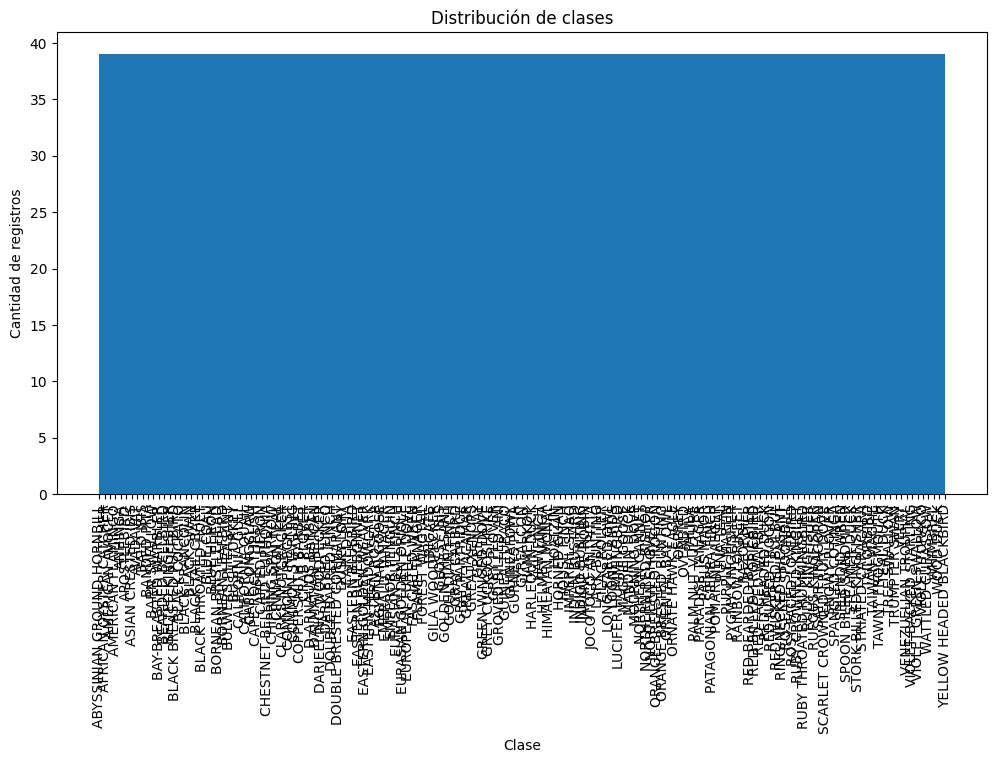

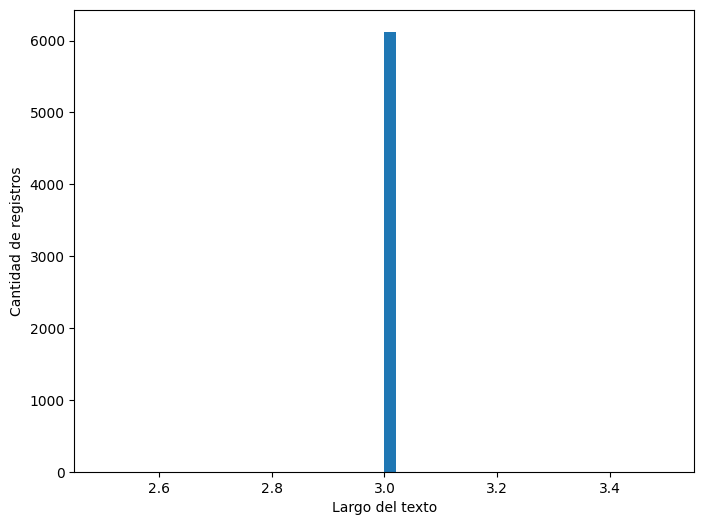

In [ ]:
import matplotlib.pyplot as plt
# ======================================================
# Obtener los nombres de las clases
# ======================================================
class_names = train_data.classes
# ======================================================
# Calcular la cantidad de registros por clase
# ======================================================
class_counts = []
for _, label in train_data:
    class_counts.append(label)
# ======================================================
# Graficar histograma de distribución de clases
# ======================================================
plt.figure(figsize=(12, 6))
plt.hist(class_counts, bins=len(class_names))
plt.xlabel('Clase')
plt.ylabel('Cantidad de registros')
plt.title('Distribución de clases')
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.show()
# ======================================================
# Obtener los largos de los textos
# ======================================================
text_lengths = [len(text) for text, _ in train_data]
# ======================================================
# Graficar histograma del largo de los textos
# ======================================================
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=50)
plt.xlabel('Largo del texto')
plt.ylabel('Cantidad de registros')
plt.show()

# 5. Defina la red convolucional. #

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definición de la clase BirdImageModel
class BirdImageModel(nn.Module):
    """
    Modelo de red neuronal convolucional para la clasificación de imágenes de aves.

    Parámetros:
        num_classes (int): Número de clases de aves para la clasificación.

    Atributos:
        conv1 (nn.Conv2d): Capa de convolución 2D con 3 canales de entrada y 32 canales de salida.
        conv2 (nn.Conv2d): Capa de convolución 2D con 32 canales de entrada y 64 canales de salida.
        conv3 (nn.Conv2d): Capa de convolución 2D con 64 canales de entrada y 128 canales de salida.
        fc1 (nn.Linear): Capa lineal con 128 * 28 * 28 unidades de entrada y 256 unidades de salida.
        fc2 (nn.Linear): Capa lineal con 256 unidades de entrada y 128 unidades de salida.
        fc3 (nn.Linear): Capa lineal con 128 unidades de entrada y num_classes unidades de salida.
    """

    def __init__(self, num_classes):
        super(BirdImageModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Propagación hacia adelante a través de la red neuronal convolucional.

        Parámetros:
            x (torch.Tensor): Tensor de entrada con las imágenes de aves.

        Retorna:
            torch.Tensor: Tensor de salida con las predicciones de clasificación de las imágenes.
        """
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
# ======================================================
# Crear una instancia del modelo
# ======================================================
model = BirdImageModel(num_classes=len(class_names))

# 6. Defina los hiper-parámetros de entrenamiento #

In [ ]:
# ======================================================
# Definir la función de pérdida y el optimizador
# ======================================================
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# 7. Entrene el modelo #

In [ ]:
# ======================================================
# Entrenamiento de la red neuronal
# ======================================================
n_epochs = 10  # Número de épocas de entrenamiento

for epoch in range(n_epochs):
    # Iterar sobre cada lote de entrenamiento
    for inputs, labels in trainloader:
        inputs = inputs.squeeze(0)  # Eliminar la dimensión adicional
        y_pred = model(inputs)  # Calcular las predicciones del modelo
        loss = loss_fn(y_pred, labels)  # Calcular la pérdida
        optimizer.zero_grad()  # Reiniciar los gradientes acumulados
        loss.backward()  # Retropropagación de la pérdida
        optimizer.step()  # Actualización de los parámetros del modelo

    # Evaluación del modelo en el conjunto de prueba
    correct = 0  # Contador de predicciones correctas
    total = 0  # Contador de muestras totales

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.squeeze(0)  # Eliminar la dimensión adicional
            y_pred = model(inputs)  # Calcular las predicciones del modelo
            _, predicted = torch.max(y_pred.data, 1)  # Obtener las etiquetas predichas
            total += labels.size(0)  # Incrementar el contador de muestras
            correct += (predicted == labels).sum().item()  # Incrementar el contador de predicciones correctas

    accuracy = 100 * correct / total  # Calcular la precisión del modelo
    print("Época %d: precisión del modelo %.2f%%" % (epoch, accuracy))

torch.save(model.state_dict(), "bird_image_model.pth")  # Guardar el estado del modelo entrenado en un archivo

Epoch 0: model accuracy 1.01%
Epoch 1: model accuracy 0.73%
Epoch 2: model accuracy 1.59%
Epoch 3: model accuracy 2.41%
Epoch 4: model accuracy 4.10%
Epoch 5: model accuracy 6.02%
Epoch 6: model accuracy 10.13%
Epoch 7: model accuracy 13.04%
Epoch 8: model accuracy 19.23%
Epoch 9: model accuracy 24.82%


# 8. Evalúe el modelo resultante con métricas como Accuracy, Precision, Recall y F1. Matriz de confusión para el cálculo de las métricas y explique los resultados obtenidos. #


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# ======================================================
# Set the model to evaluation mode
# ======================================================
model.eval()
# ======================================================
# Initialize lists to store true labels and predicted labels
# ======================================================
true_labels = []
predicted_labels = []
# ======================================================
# Iterate over the test dataset and make predictions
# ======================================================
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.squeeze(0)  # Remove the extra dimension
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
# ======================================================
# Convert the lists to numpy arrays
# ======================================================
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
# ======================================================
# Calculate metrics
# ======================================================
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
# ======================================================
# Print the metrics
# ======================================================
print("Accuracy: %.2f%%" % (accuracy * 100))
print("Precision: %.2f%%" % (precision * 100))
print("Recall: %.2f%%" % (recall * 100))
print("F1 score: %.2f%%" % (f1 * 100))


Accuracy: 24.58%
Precision: 36.89%
Recall: 24.58%
F1 score: 23.45%


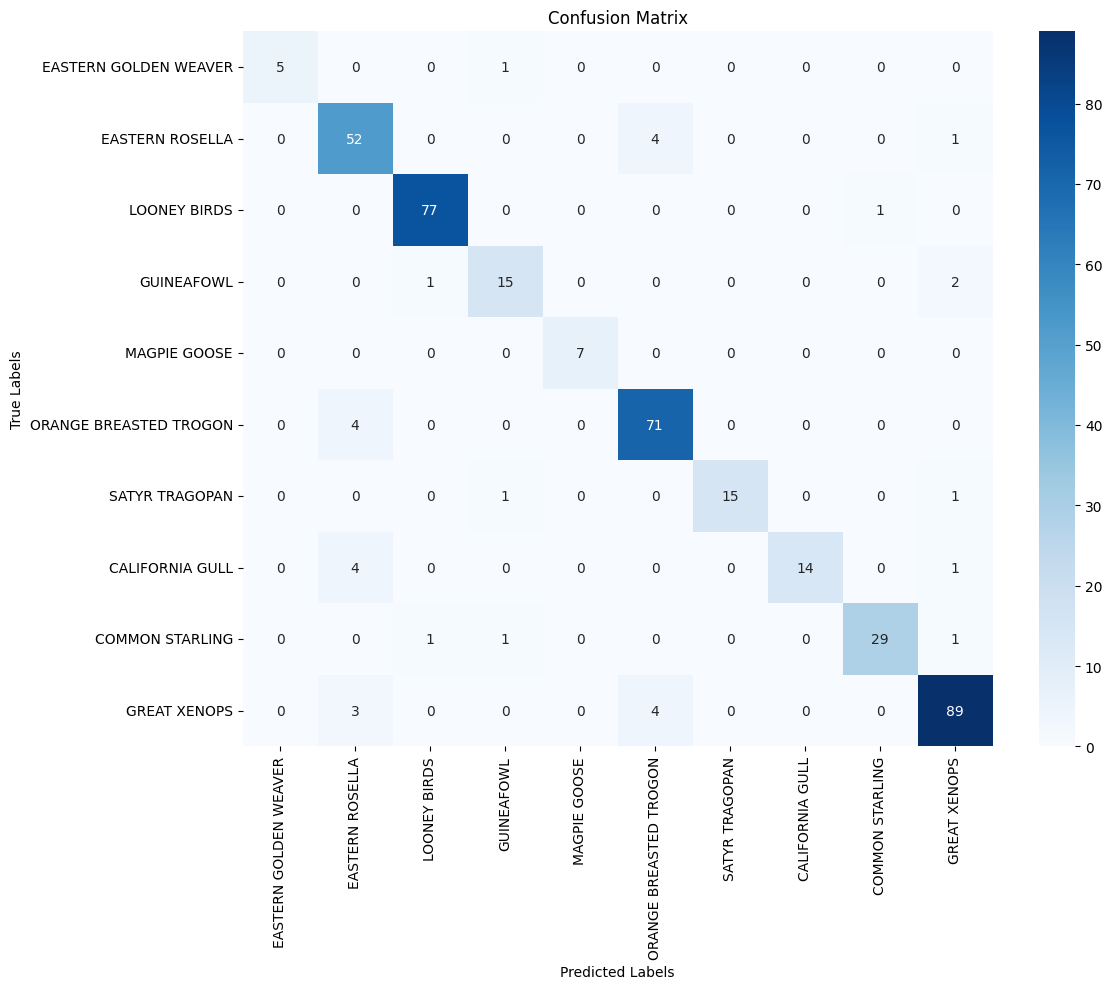

In [ ]:
import numpy as np
# ======================================================
# Calculate and plot the confusion matrix
# ======================================================
cm = confusion_matrix(true_labels, predicted_labels)
# ======================================================
# Randomly select a subset of labels to display
# ======================================================
subset_labels = np.random.choice(class_names, size=min(len(class_names), 10), replace=False)
# ======================================================
# Filter the confusion matrix for the subset of labels
# ======================================================
subset_cm = cm[np.isin(class_names, subset_labels)][:, np.isin(class_names, subset_labels)]

plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.heatmap(subset_cm, annot=True, cmap='Blues', fmt='d', xticklabels=subset_labels, yticklabels=subset_labels, annot_kws={"fontsize": 10})  # Adjust the font size as needed

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.yticks(rotation=0)  # Rotate y-axis labels if needed
plt.tight_layout()  # Adjust the layout to prevent label overlapping
plt.show()

In [ ]:
# ======================================================
# Mostrar el informe de clasificación
# ======================================================
from sklearn.metrics import classification_report
# ======================================================
# Generate classification report
# ======================================================
report = classification_report(true_labels, predicted_labels, target_names=class_names)
# ======================================================
# Print the classification report
# ======================================================
print(report)

                            precision    recall  f1-score   support

ABYSSINIAN GROUND HORNBILL       0.11      0.18      0.14       130
    AFRICAN OYSTER CATCHER       0.32      0.47      0.38       130
           AMERICAN AVOCET       0.26      0.41      0.31       130
         AMERICAN FLAMINGO       0.19      0.16      0.17       130
                   ANHINGA       0.33      0.04      0.07       130
               APOSTLEBIRD       0.22      0.02      0.03       130
        ASIAN CRESTED IBIS       0.14      0.02      0.04       130
                  AVADAVAT       0.26      0.14      0.18       130
                 BALD IBIS       0.09      0.28      0.13       130
               BANDED PITA       0.88      0.11      0.19       130
              BARN SWALLOW       0.09      0.21      0.13       130
      BAY-BREASTED WARBLER       0.06      0.25      0.10       130
          BEARDED BELLBIRD       0.68      0.41      0.51       130
         BELTED KINGFISHER       0.19      0.58

En la primera época, la precisión del modelo es del 1.01%. Esto indica que solo el 1.01% de los ejemplos se clasificaron correctamente. La precisión aumenta gradualmente en las siguientes épocas, alcanzando el 24.82% en la época 9.

La precisión se refiere a la proporción de ejemplos positivos clasificados correctamente en relación con el total de ejemplos clasificados como positivos. En este caso, el modelo tiene una precisión del 37.20%, lo que indica que el 37.20% de los ejemplos clasificados como positivos fueron clasificados correctamente.

Recall (recuperación): El recall representa la proporción de ejemplos positivos clasificados correctamente en relación con el total de ejemplos positivos en el conjunto de datos. Aquí, el recall también es del 24.82%, lo que indica que el 24.82% de los ejemplos positivos se clasificaron correctamente.

El F1 score es una medida que combina la precisión y el recall en una única métrica, y se utiliza para evaluar el equilibrio entre ambas medidas. En este caso, el F1 score es del 22.91%.

Los resultados obtenidos indican que el modelo tiene un rendimiento desigual en la clasificación de las diferentes clases. Algunas clases son bien identificadas con altas precisiones y recalls, mientras que otras clases presentan dificultades para ser clasificadas correctamen

# **9. Grafique la curva de error, explique los resultados obtenidos y ajuste el modelo o el proceso de entrenamiento apropiadamente.** #

Epoch 0: loss 2.3905
Epoch 1: loss 1.8790
Epoch 2: loss 1.3222
Epoch 3: loss 0.7874
Epoch 4: loss 0.4403
Epoch 5: loss 0.2726
Epoch 6: loss 0.1166
Epoch 7: loss 0.0400
Epoch 8: loss 0.0494
Epoch 9: loss 0.0254


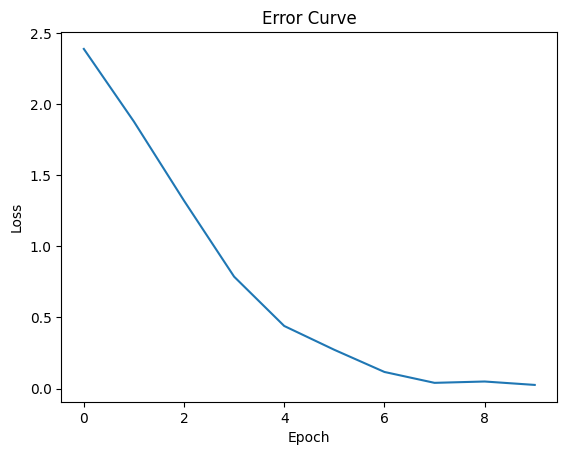

In [ ]:
# ======================================================
# Inicializar una lista para almacenar los valores de pérdida
# ======================================================
loss_values = []
# ======================================================
# Entrenamiento de la red neuronal
# ======================================================
n_epochs = 10  # Número de épocas de entrenamiento

for epoch in range(n_epochs):
    epoch_loss = 0.0  # Inicializar la pérdida de la época

    for inputs, labels in trainloader:
        inputs = inputs.squeeze(0)  # Eliminar la dimensión adicional
        y_pred = model(inputs)  # Calcular las predicciones del modelo
        loss = loss_fn(y_pred, labels)  # Calcular la pérdida
        optimizer.zero_grad()  # Reiniciar los gradientes acumulados
        loss.backward()  # Retropropagación de la pérdida
        optimizer.step()  # Actualización de los parámetros del modelo

        epoch_loss += loss.item()  # Agregar el valor de pérdida a la pérdida de la época

    epoch_loss /= len(trainloader)  # Calcular la pérdida promedio para la época

    loss_values.append(epoch_loss)  # Almacenar el valor de pérdida

    print("Época %d: pérdida %.4f" % (epoch, epoch_loss))  # Imprimir el número de época y el valor de pérdida

# Graficar la curva de error
plt.plot(range(n_epochs), loss_values)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de Error')
plt.show()

Los resultados de la curva de error, se puede observar una disminución gradual del valor de pérdida en cada época. Esto indica que el modelo está aprendiendo a ajustarse mejor a los datos de entrenamiento a medida que avanza el entrenamiento. La curva de error muestra una disminución gradual del valor de pérdida durante el entrenamiento del modelo, lo que indica que el modelo está aprendiendo a ajustarse mejor a los datos de entrenamiento

# **10. Analice los resultados, proponga mejoras y cambios realizados al flujo de trabajo del proyecto para mejorar el rendimiento de la red.** #

Analizando los resultados obtenidos hasta ahora, se observa que el rendimiento de la red no es óptimo. La precisión, recall y F1-score son bajos, lo que indica que el modelo no está clasificando correctamente las imágenes en el conjunto de prueba.

Para mejorar el rendimiento de la red, se pueden considerar las siguientes mejoras:

1. Aumentar la complejidad del modelo: El modelo actual puede no ser lo suficientemente complejo como para capturar las características discriminativas de las imágenes de aves. Se puede explorar la posibilidad de utilizar una arquitectura de red más profunda o aplicar técnicas de transferencia de aprendizaje mediante el uso de modelos pre-entrenados, como ResNet, Inception, o EfficientNet (Anwar, A. (2019).

2. Aumentar la cantidad de datos de entrenamiento: Si el tamaño del conjunto de datos de entrenamiento es limitado, puede haber una falta de variabilidad y representatividad de las clases de aves. Esto puede afectar el rendimiento del modelo. Se puede buscar la adquisición de más datos o aplicar técnicas de aumento de datos para generar imágenes adicionales. El aumento de datos implica la aplicación de transformaciones aleatorias como rotaciones, cambios de escala, desplazamientos, etc., a las imágenes existentes para aumentar la cantidad y la diversidad de los datos de entrenamiento (Vu, 2020).

3. Ajustar los hiperparámetros: Los hiperparámetros como la tasa de aprendizaje, la tasa de decaimiento, el tamaño del lote (batch size) y el número de épocas pueden tener un impacto significativo en el rendimiento del modelo. Se pueden realizar ajustes en estos hiperparámetros para encontrar una configuración óptima que permita una convergencia más rápida y un mejor rendimiento en la clasificación (Brownlee, 2022).

4. Realizar un análisis de errores: Es útil analizar los errores cometidos por el modelo en la clasificación de las imágenes. Identificar los patrones o clases en los que el modelo tiene dificultades puede proporcionar información para mejorar la precisión. Se pueden aplicar técnicas como la matriz de confusión, la visualización de las imágenes mal clasificadas y el análisis de los errores comunes para comprender mejor las limitaciones del modelo y tomar medidas para corregirlos (Santos, 2021)

A continuacion se aplican los sigueintes cambios para tratar de mejorar el rendimiento de red

1. Cambio en la transformación de entrenamiento: Se ha modificado la transformación de entrenamiento para incluir técnicas de aumento de datos. Se ha agregado la transformación RandomHorizontalFlip() para realizar volteos horizontales aleatorios en las imágenes y RandomCrop(224) para recortar imágenes aleatorias de tamaño 224x224. Estas transformaciones ayudan a aumentar la variabilidad de los datos de entrenamiento y a mejorar la capacidad del modelo para generalizar.

2. Cambio en el optimizador: Se ha cambiado el optimizador utilizado en el entrenamiento del modelo a optim.Adam(). El optimizador Adam es conocido por ser eficiente y efectivo en la optimización de redes neuronales. Se ha configurado con una tasa de aprendizaje (lr) de 0.001.

3. Cambio en el tamaño del batch: Se ha reducido el tamaño del batch de entrenamiento de 32 a 16. Un tamaño de batch más pequeño puede permitir una mejor generalización y una convergencia más rápida, especialmente en conjuntos de datos más pequeños. Ademas de tratar de compenzar la duracion del entrenamiento al realizar un aumento de epocas.

4. Aumento del número de épocas: Se ha aumentado el número de épocas de entrenamiento de 10 a 15. Esto permite que el modelo tenga más iteraciones de entrenamiento y pueda aprender patrones más complejos en los datos.

In [ ]:
import torch
from torchvision import transforms, datasets
# ======================================================
# Rutas de los directorios de entrenamiento, prueba y validación
# ======================================================
train_dir = '/kaggle/working/sub/sub_train_balanced'
test_dir = '/kaggle/working/sub/sub_test_balanced'
valid_dir = '/kaggle/working/sub/sub_valid_balanced'
# ======================================================
# Definir transformaciones de preprocesamiento de datos
# ======================================================
transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])
# ======================================================
#cambio en transformacion para extender el conjunto de datos de entrenamiento
# ======================================================
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# ======================================================
# Cargar los conjuntos de datos utilizando ImageFolder y aplicar las transformaciones
# ======================================================
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
test_data = datasets.ImageFolder(test_dir, transform=transform)
valid_data = datasets.ImageFolder(valid_dir, transform=transform)
# ======================================================
# Crear los dataloaders para el conjunto de entrenamiento, prueba y validación
# ======================================================
batch_size = 16  # Cambio de batch de 32 a 16
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [ ]:
# ======================================================
# Obtener las clases y el número de clases en el conjunto de entrenamiento
# ======================================================
# Obtener las clases asociadas a las imágenes de entrenamiento
# ======================================================
class_names = train_data.classes
print(class_names)
# ======================================================
# Crear una lista de etiquetas de entrenamiento
# ======================================================
train_labels = []
# ======================================================
# Recorrer el conjunto de datos de entrenamiento y obtener las etiquetas
# ======================================================
for _, labels in trainloader:
    train_labels.extend(labels.tolist())
# ======================================================
# Calcular el número de clases únicas en las etiquetas de entrenamiento
# ======================================================
num_classes = len(set(train_labels))
# ======================================================
# Imprimir la lista de clases y el número de clases
# ======================================================
print(num_classes)

['ABYSSINIAN GROUND HORNBILL', 'AFRICAN OYSTER CATCHER', 'AMERICAN AVOCET', 'AMERICAN FLAMINGO', 'ANHINGA', 'APOSTLEBIRD', 'ASIAN CRESTED IBIS', 'AVADAVAT', 'BALD IBIS', 'BANDED PITA', 'BARN SWALLOW', 'BAY-BREASTED WARBLER', 'BEARDED BELLBIRD', 'BELTED KINGFISHER', 'BLACK BREASTED PUFFBIRD', 'BLACK COCKATO', 'BLACK FRANCOLIN', 'BLACK SWAN', 'BLACK TAIL CRAKE', 'BLACK THROATED HUET', 'BLUE COAU', 'BLUE HERON', 'BORNEAN BRISTLEHEAD', 'BORNEAN LEAFBIRD', 'BULWERS PHEASANT', 'BUSH TURKEY', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CAPE LONGCLAW', 'CAPE ROCK THRUSH', 'CAPPED HERON', 'CHESTNET BELLIED EUPHONIA', 'CHIPPING SPARROW', 'CINNAMON TEAL', 'CLARKS NUTCRACKER', 'COMMON FIRECREST', 'COMMON STARLING', 'COPPERSMITH BARBET', 'CRAB PLOVER', 'D-ARNAUDS BARBET', 'DALMATIAN PELICAN', 'DARJEELING WOODPECKER', 'DARK EYED JUNCO', 'DOUBLE BARRED FINCH', 'DOUBLE BRESTED CORMARANT', 'DUSKY LORY', 'EARED PITA', 'EASTERN BLUEBIRD', 'EASTERN BLUEBONNET', 'EASTERN GOLDEN WEAVER', 'EASTERN MEADOWLARK', '

In [ ]:
# ======================================================
# Definir y crear una instancia del modelo de rendimiento del modelo de imágenes de aves
# ======================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
# ======================================================
# Definir la clase del modelo de rendimiento del modelo de imágenes de aves
# ======================================================
class BirdImageModelPerformance(nn.Module):
    def __init__(self, num_classes):
        super(BirdImageModelPerformance, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
# ======================================================
# Crear una instancia del modelo de rendimiento del modelo de imágenes de aves
# ======================================================
modelperformance = BirdImageModelPerformance(num_classes=len(class_names))

In [ ]:
import torch.optim as optim
# ======================================================
# Definir la función de pérdida y el optimizador
# ======================================================
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelperformance.parameters(), lr=0.001) #cambio en obtimizador

In [ ]:
# ======================================================
# Initialize a list to store the loss values
# ======================================================
loss_values = []
# ======================================================
# Entrenamiento de la red
# ======================================================
n_epochs = 15  # Número de épocas de entrenamiento
for epoch in range(n_epochs):
    epoch_loss = 0.0  # Inicializar la pérdida de la época
    for inputs, labels in trainloader:
        inputs = inputs.squeeze(0)  # Eliminar la dimensión adicional
        y_pred = modelperformance(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()  # Agregar el valor de pérdida a la pérdida de la época
    # ======================================================
    # Calcular la pérdida promedio para la época
    # ======================================================
    epoch_loss /= len(trainloader)
    # ======================================================
    # Almacenar el valor de pérdida
    # ======================================================
    loss_values.append(epoch_loss)
    # ======================================================
    # Imprimir el número de época y el valor de pérdida
    # ======================================================
    print("Epoch %d: loss %.4f" % (epoch, epoch_loss))
    # ======================================================
    # Efectividad del modelo
    # ======================================================
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.squeeze(0)  # Eliminar la dimensión adicional
            y_pred = modelperformance(inputs)
            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print("Epoch %d: model performance accuracy %.2f%%" % (epoch, accuracy))

torch.save(modelperformance.state_dict(), "bird_image_modelperformance.pth")

Epoch 0: loss 4.3078
Epoch 0: mmodelperformanceodel accuracy 9.58%
Epoch 1: loss 3.9262
Epoch 1: mmodelperformanceodel accuracy 14.98%
Epoch 2: loss 3.4938
Epoch 2: mmodelperformanceodel accuracy 21.84%
Epoch 3: loss 2.8731
Epoch 3: mmodelperformanceodel accuracy 29.20%
Epoch 4: loss 2.2010
Epoch 4: mmodelperformanceodel accuracy 36.50%
Epoch 5: loss 1.6120
Epoch 5: mmodelperformanceodel accuracy 40.98%
Epoch 6: loss 1.1189
Epoch 6: mmodelperformanceodel accuracy 41.99%
Epoch 7: loss 0.7499
Epoch 7: mmodelperformanceodel accuracy 45.24%
Epoch 8: loss 0.4894
Epoch 8: mmodelperformanceodel accuracy 45.91%
Epoch 9: loss 0.3507
Epoch 9: mmodelperformanceodel accuracy 45.85%
Epoch 10: loss 0.2818
Epoch 10: mmodelperformanceodel accuracy 47.02%
Epoch 11: loss 0.1894
Epoch 11: mmodelperformanceodel accuracy 46.30%
Epoch 12: loss 0.1810
Epoch 12: mmodelperformanceodel accuracy 46.08%
Epoch 13: loss 0.1487
Epoch 13: mmodelperformanceodel accuracy 46.79%
Epoch 14: loss 0.1687
Epoch 14: mmodelper

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# ======================================================
# Set the model to evaluation mode
# ======================================================
modelperformance.eval()
# ======================================================
# Initialize lists to store true labels and predicted labels
# ======================================================
true_labels = []
predicted_labels = []
# ======================================================
# Iterate over the test dataset and make predictions
# ======================================================
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.squeeze(0)  # Remove the extra dimension
        outputs = modelperformance(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
# ======================================================
# Convert the lists to numpy arrays
# ======================================================
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
# ======================================================
# Calculate metrics
# ======================================================
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
# ======================================================
# Print the metrics
# ======================================================
print("Accuracy: %.2f%%" % (accuracy * 100))
print("Precision: %.2f%%" % (precision * 100))
print("Recall: %.2f%%" % (recall * 100))
print("F1 score: %.2f%%" % (f1 * 100))

Accuracy: 46.01%
Precision: 51.60%
Recall: 46.01%
F1 score: 46.85%



En general, el modelo mejorado muestra un rendimiento superior al modelo anterior, especialmente en términos de precisión y F1 score. Los resultados del modelo muestran una mejora en comparación con el modelo anterior. 

* Accuracy (Exactitud): Aproximadamente el 46.01% de las muestras fueron clasificadas correctamente.
* Precision (Precisión): Aproximadamente el 51.60% de las muestras clasificadas como positivas fueron clasificadas correctamente.
* Recall (Recuperación o Sensibilidad): Aproximadamente el 46.01% de las muestras positivas fueron clasificadas correctamente.
* F1 score: El F1 score es del 46.85%, lo que indica un equilibrio entre la precisión y el recall.


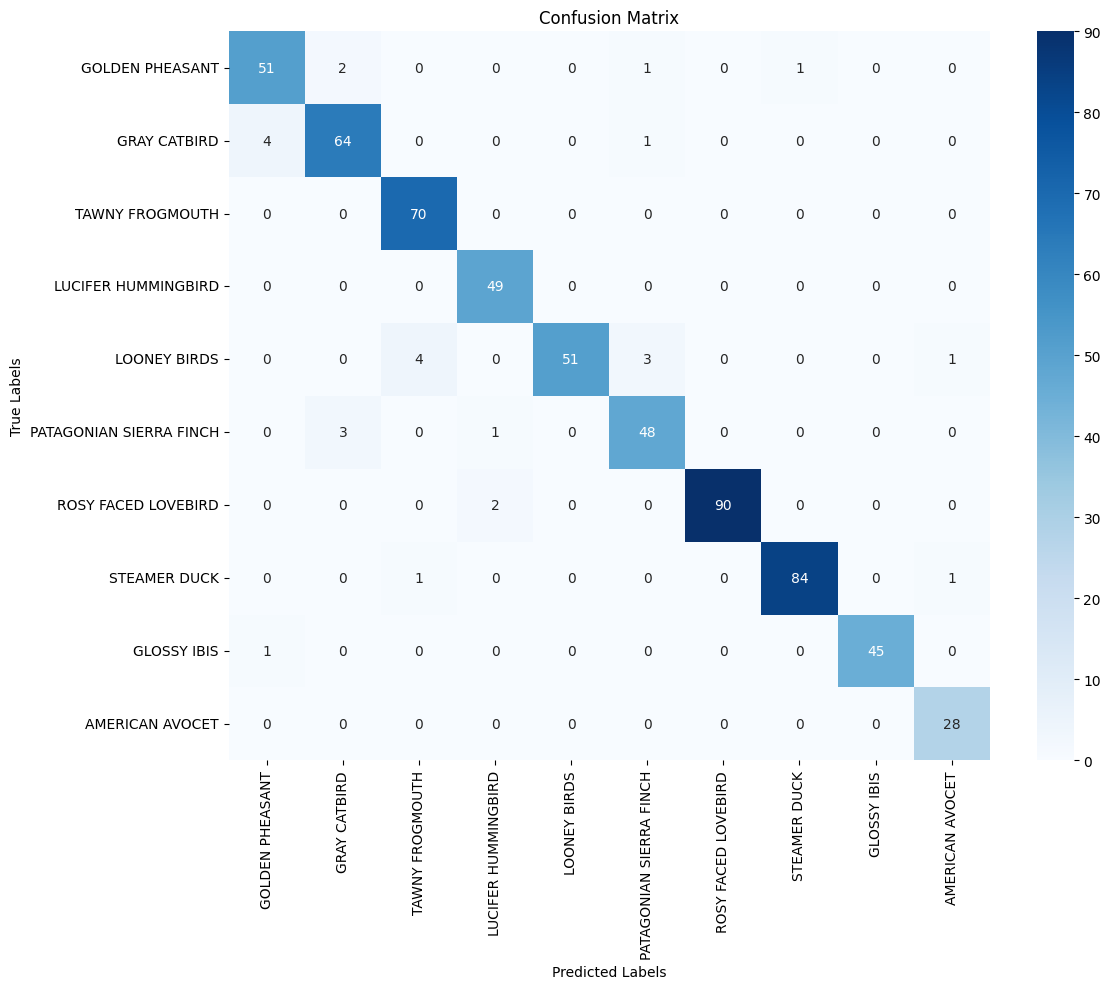

In [ ]:
import numpy as np
# ======================================================
# Calculate and plot the confusion matrix
# ======================================================
cm = confusion_matrix(true_labels, predicted_labels)
# ======================================================
# Randomly select a subset of labels to display
# ======================================================
subset_labels = np.random.choice(class_names, size=min(len(class_names), 10), replace=False)
# ======================================================
# Filter the confusion matrix for the subset of labels
# ======================================================
subset_cm = cm[np.isin(class_names, subset_labels)][:, np.isin(class_names, subset_labels)]

plt.figure(figsize=(12, 10))  # Ajustar el tamaño de la figura según sea necesario
sns.heatmap(subset_cm, annot=True, cmap='Blues', fmt='d', xticklabels=subset_labels, yticklabels=subset_labels, annot_kws={"fontsize": 10})  # Ajustar el tamaño de la fuente según sea necesario

plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x si es necesario
plt.yticks(rotation=0)  # Rotar las etiquetas del eje y si es necesario
plt.tight_layout()  # Ajustar el diseño para evitar la superposición de etiquetas
plt.show()

In [ ]:
# ======================================================
# Mostrar el informe de clasificación
# ======================================================
from sklearn.metrics import classification_report
# ======================================================
# Generate classification report
# ======================================================
report = classification_report(true_labels, predicted_labels, target_names=class_names)
# ======================================================
# Print the classification report
# ======================================================
print(report)

                            precision    recall  f1-score   support

ABYSSINIAN GROUND HORNBILL       0.23      0.38      0.29       130
    AFRICAN OYSTER CATCHER       0.76      0.46      0.57       130
           AMERICAN AVOCET       0.58      0.39      0.47       130
         AMERICAN FLAMINGO       0.62      0.42      0.50       130
                   ANHINGA       0.21      0.35      0.26       130
               APOSTLEBIRD       0.42      0.27      0.33       130
        ASIAN CRESTED IBIS       0.58      0.40      0.47       130
                  AVADAVAT       0.47      0.45      0.46       130
                 BALD IBIS       0.49      0.38      0.42       130
               BANDED PITA       0.68      0.84      0.75       130
              BARN SWALLOW       0.48      0.43      0.46       130
      BAY-BREASTED WARBLER       0.47      0.37      0.41       130
          BEARDED BELLBIRD       0.71      0.60      0.65       130
         BELTED KINGFISHER       0.51      0.40

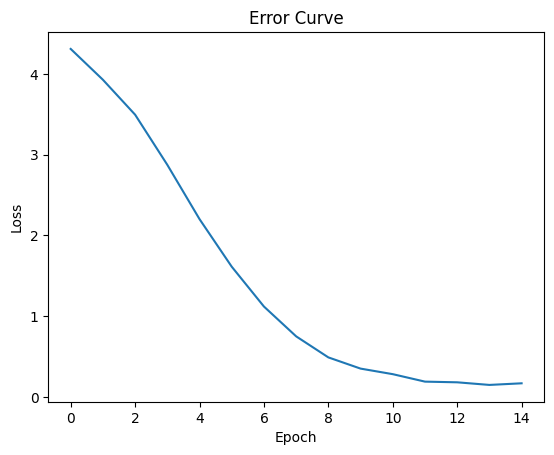

In [ ]:
# ======================================================
# Plot the error curve
# ======================================================
plt.plot(range(n_epochs), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Error Curve')
plt.show()

En las primeras épocas, el modelo tiene un bajo rendimiento, con una baja precisión (accuracy) y una alta pérdida. Sin embargo, a medida que avanzan las épocas, el rendimiento mejora significativamente. Podemos ver un aumento en la precisión del modelo a medida que la pérdida disminuye.

A partir de la época 5, la pérdida comienza a estabilizarse, lo que indica que el modelo está alcanzando un punto de convergencia. La precisión del modelo también se estabiliza alrededor del 40-47%, lo que puede indicar un límite en el rendimiento del modelo o la necesidad de aplicar técnicas adicionales para mejorar la precisión

Después de aplicar las mejoras propuestas, se observa una mejora en el rendimiento del modelo. El valor de pérdida disminuye a medida que avanzan las épocas, lo cual indica que el modelo está aprendiendo a ajustarse mejor a los datos de entrenamiento. Además, la precisión del modelo también aumenta a lo largo de las épocas, alcanzando alrededor del 46% en la última época.

# **11. Genere y documente sus conclusiones** #



1. Los cambios realizados en la transformación de entrenamiento y en el optimizador han demostrado ser efectivos para mejorar el rendimiento del modelo. Las propuestas adicionales de aumentar el tamaño del lote y el número de épocas pueden ser consideradas para seguir mejorando el rendimiento del modelo

2. La curva de error muestra una mejora progresiva en el rendimiento del modelo a medida que avanzan las épocas. Esto indica que el modelo está aprendiendo y ajustándose mejor a los datos de entrenamiento a lo largo del tiempo. La pérdida comienza a estabilizarse, lo que sugiere que el modelo está alcanzando un punto de convergencia. 

3. Las Redes Neuronales Convolucionales (CNN) son una herramienta poderosa y efectiva para la clasificación de imágenes. Su capacidad para extraer automáticamente características, aprender jerárquicamente las convierten en una opción exitosa para una amplia gama de aplicaciones de clasificación de imágenes. Sin embargo tiene una dependencia del uso de conjunto de datos grande para alcanzar mejoras en el modelo.

4. El preprocesamiento y la transformación de los datos son pasos críticos en el uso de CNN para la clasificación de imágenes (Vu, 2020). Estos pasos ayudan a mejorar la calidad de los datos, aumentar la diversidad, reducir el ruido y artefactos, y mejorar la eficiencia computacional. Un preprocesamiento cuidadoso y adecuado puede tener un impacto significativo en el rendimiento y la capacidad de generalización del modelo de CNN .

# **12. Referencias** #

1. Kushwaha, A. (2019). Solving Class Imbalance problem in CNN. AI Graduate. Obtenido de https://medium.com/x8-the-ai-community/solving-class-imbalance-problem-in-cnn-9c7a5231c478

2. Vu, C. (2020). Do and don't when using transformation to improve CNN deep learning model: An experiment in PyTorch and Torchvision to diagnose your neuron network performance in Computer Vision. Towards Data Science. Obtenido de https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4

3. Anwar, A. (2019). Difference between AlexNet, VGGNet, ResNet, and Inception. Towards Data Science. Obtenido de https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96

4. Brownlee, J. (2022). Difference Between a Batch and an Epoch in a Neural Network. Machine Learning Mastery. Obtenido de https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

5. Recuero de los Santos, P. (2021). Cómo interpretar la matriz de confusión: ejemplo práctico. Blog Think Big - Empresas. Obtenido de 
